# Necessary Packages

In [29]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import nltk
from nltk.probability import FreqDist
from wordcloud import WordCloud
import spacy


In [30]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load("en_core_web_sm") # python3 -m spacy download en_core_web_sm

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Reem\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Reem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Preprocessing

In [31]:
# Load the dataset
df = pd.read_csv('Food Ingredients and Recipe Dataset with Image Name Mapping.csv', index_col=0)
df.head()

,Title,Ingredients,Instructions,Image_Name,Cleaned_Ingredients
0,Miso-Butter Roast Chicken With Acorn Squash Pa...,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher...","Pat chicken dry with paper towels, season all ...",miso-butter-roast-chicken-acorn-squash-panzanella,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher..."
1,Crispy Salt and Pepper Potatoes,"['2 large egg whites', '1 pound new potatoes (...",Preheat oven to 400°F and line a rimmed baking...,crispy-salt-and-pepper-potatoes-dan-kluger,"['2 large egg whites', '1 pound new potatoes (..."
2,Thanksgiving Mac and Cheese,"['1 cup evaporated milk', '1 cup whole milk', ...",Place a rack in middle of oven; preheat to 400...,thanksgiving-mac-and-cheese-erick-williams,"['1 cup evaporated milk', '1 cup whole milk', ..."
3,Italian Sausage and Bread Stuffing,"['1 (¾- to 1-pound) round Italian loaf, cut in...",Preheat oven to 350°F with rack in middle. Gen...,italian-sausage-and-bread-stuffing-240559,"['1 (¾- to 1-pound) round Italian loaf, cut in..."
4,Newton's Law,"['1 teaspoon dark brown sugar', '1 teaspoon ho...",Stir together brown sugar and hot water in a c...,newtons-law-apple-bourbon-cocktail,"['1 teaspoon dark brown sugar', '1 teaspoon ho..."


In [32]:
# Drop the Image_Name column
df = df.drop('Image_Name', axis = 1)
df.head()

,Title,Ingredients,Instructions,Cleaned_Ingredients
0,Miso-Butter Roast Chicken With Acorn Squash Pa...,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher...","Pat chicken dry with paper towels, season all ...","['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher..."
1,Crispy Salt and Pepper Potatoes,"['2 large egg whites', '1 pound new potatoes (...",Preheat oven to 400°F and line a rimmed baking...,"['2 large egg whites', '1 pound new potatoes (..."
2,Thanksgiving Mac and Cheese,"['1 cup evaporated milk', '1 cup whole milk', ...",Place a rack in middle of oven; preheat to 400...,"['1 cup evaporated milk', '1 cup whole milk', ..."
3,Italian Sausage and Bread Stuffing,"['1 (¾- to 1-pound) round Italian loaf, cut in...",Preheat oven to 350°F with rack in middle. Gen...,"['1 (¾- to 1-pound) round Italian loaf, cut in..."
4,Newton's Law,"['1 teaspoon dark brown sugar', '1 teaspoon ho...",Stir together brown sugar and hot water in a c...,"['1 teaspoon dark brown sugar', '1 teaspoon ho..."


In [33]:
# Check for dataset count and possible missing values
df.count()

Title                  13496
Ingredients            13501
Instructions           13493
Cleaned_Ingredients    13501
dtype: int64

In [34]:
# Check for missing values
df.isna().sum()

Title                  5
Ingredients            0
Instructions           8
Cleaned_Ingredients    0
dtype: int64

In [35]:
# Drop missing values
df = df.dropna()

In [36]:
# Check for missing values again
df.isna().sum()

Title                  0
Ingredients            0
Instructions           0
Cleaned_Ingredients    0
dtype: int64

In [37]:
# Check for dataset count and possible missing values after dropping missing values
df.count()

Title                  13493
Ingredients            13493
Instructions           13493
Cleaned_Ingredients    13493
dtype: int64

In [38]:
# Basic statistics
word_count = df['Cleaned_Ingredients'].apply(lambda x: len(nltk.word_tokenize(x)))
sentence_count = df['Cleaned_Ingredients'].apply(lambda x: len(nltk.sent_tokenize(x)))
char_count = df['Cleaned_Ingredients'].apply(len)

# Display basic statistics
print(word_count, sentence_count, char_count)

0        229
1         62
2         88
3        140
4         57
        ... 
13496    103
13497    102
13498     65
13499     58
13500    202
Name: Cleaned_Ingredients, Length: 13493, dtype: int64 0        15
1         1
2         9
3         1
4         3
         ..
13496     1
13497     1
13498     1
13499     1
13500     1
Name: Cleaned_Ingredients, Length: 13493, dtype: int64 0        830
1        251
2        289
3        558
4        218
        ... 
13496    413
13497    405
13498    271
13499    211
13500    762
Name: Cleaned_Ingredients, Length: 13493, dtype: int64


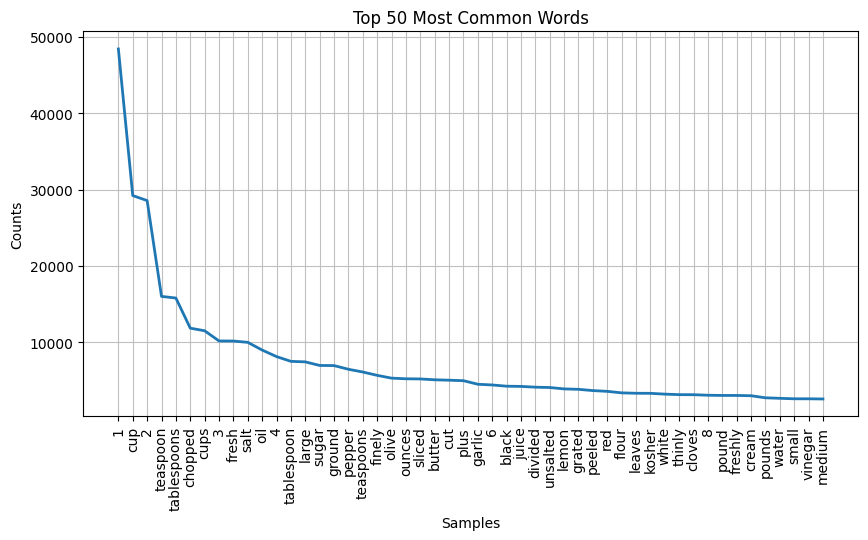

<Axes: title={'center': 'Top 50 Most Common Words'}, xlabel='Samples', ylabel='Counts'>

In [45]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

# Tokenize and remove stop words
df['tokens'] = df['Cleaned_Ingredients'].apply(lambda x: [word for word in nltk.word_tokenize(x.lower()) if word.isalnum() and word not in stop_words])

# Frequency distribution of words
all_words = [word for tokens_list in df['tokens'] for word in tokens_list]
freq_dist = FreqDist(all_words)

# Plot the most common words
plt.figure(figsize=(10, 5))
freq_dist.plot(50, title='Top 50 Most Common Words')


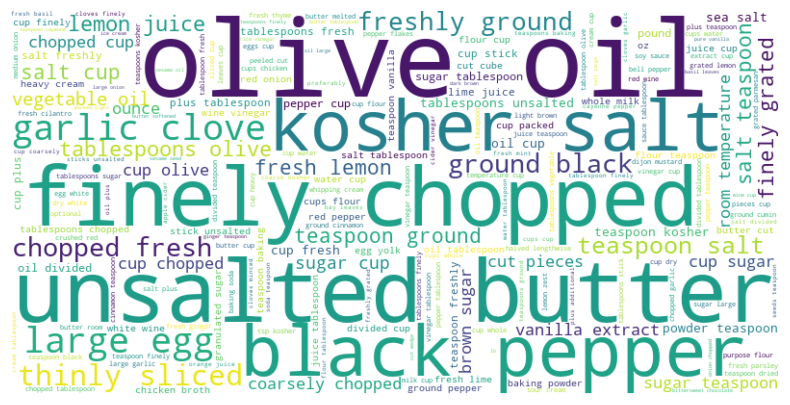

In [40]:
# Generate and display a word cloud
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(all_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


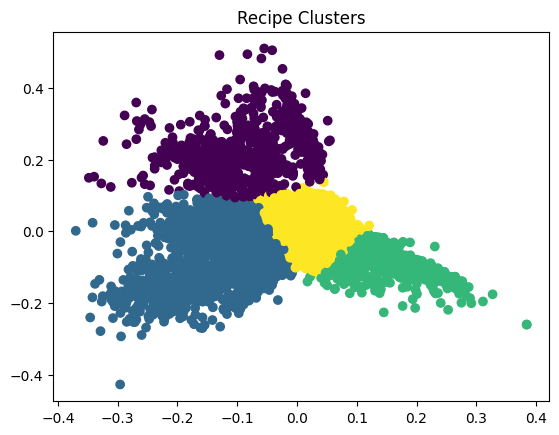

In [41]:
# Vectorization
vectorizer = TfidfVectorizer()
titles = vectorizer.fit_transform(df['Title'])

# Dimensionality Reduction
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(titles.toarray())

# Clustering
kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit_predict(X_reduced)
df['Cluster'] = clusters    
# Visualization
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters)
plt.title('Recipe Clusters')
plt.show()


# Model

In [42]:
# we are prediciting based on ingredients so we will use ingredients column
vectorizer = TfidfVectorizer()
ingredients_matrix = vectorizer.fit_transform(df['Cleaned_Ingredients'])
kmeans = KMeans(n_clusters=4, random_state=0)
df['Ingredients_Cluster'] = kmeans.fit_predict(ingredients_matrix)

In [43]:
# the recommended dishes function based on the ingredients
def recommend_dishes(data, user_input, n_recommendations):
    user_input = user_input.lower()
    user_vector = vectorizer.transform([user_input])

    user_cluster = kmeans.predict(user_vector)[0]
    cluster_data = data[data['Cluster'] == user_cluster]
    cluster_matrix = vectorizer.transform(cluster_data['Cleaned_Ingredients'])
    
    similarities = cosine_similarity(user_vector, cluster_matrix)
    top_indices = similarities[0].argsort()[-n_recommendations:][::-1]
    recommended_dishes = cluster_data.iloc[top_indices]
    
    return recommended_dishes[['Title', 'Cleaned_Ingredients', 'Instructions']]


In [44]:
# Test the function
data = df
user_input = 'chicken, rice'
n_recommendations = 5
recommend_dishes(data, user_input, n_recommendations)

,Title,Cleaned_Ingredients,Instructions
2599,Fully Salted Roast Chicken,"['1 (3 1/2–4-lb.) chicken', 'Kosher salt']",Pat dry chicken with paper towels. Holding a 5...
2946,"Easy Green Curry with Chicken, Bell Pepper, an...","['1 tablespoon virgin coconut or canola oil', ...",Heat oil in a medium pot over medium. Cook cur...
5203,Caramel Chicken,"['2 tablespoons vegetable oil', '2 1/2 pounds ...",Heat oil in a large wide heavy pot over medium...
6398,Sweet and Spicy Chicken Drumsticks,"['1/2 cup Sriracha', '1/2 cup unseasoned rice ...","Bring Sriracha, rice vinegar, mirin, and jelly..."
1320,Chicken Teriyaki,"['5 skin-on, boneless chicken thighs (about 1 ...",Place chicken on a cutting board and poke seve...
